In [1]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#hide
!pip install fastai -Uqq
!pip install timm -Uqq

     |████████████████████████████████| 197 kB 5.3 MB/s 
     |████████████████████████████████| 60 kB 6.8 MB/s 
     |████████████████████████████████| 431 kB 5.3 MB/s 


In [3]:
#hide 
import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from timm import create_model
from timm.models.efficientnet_blocks import DepthwiseSeparableConv

from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")

# Implementing the paper - `A Simple Baseline for Fast and Accurate Depth Estimation on Mobile Devices` 

> implementing a paper

- toc:true
- branch: master
- badges: true
- comments: true
- author: Mohamed Arshath
- categories: [computer vision, depth estimation, paper implementation, fastai]

**Resources**
1. [Paper](https://ieeexplore.ieee.org/document/9523055)


## About the paper

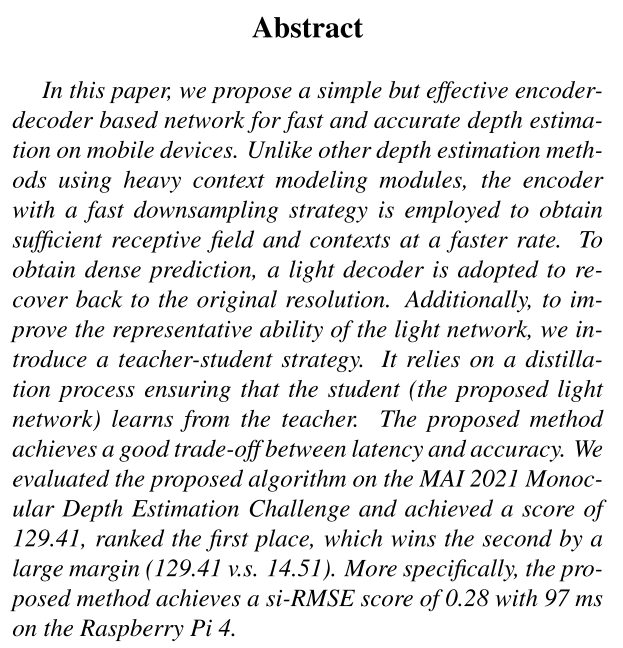

The paper proposes a simple encoder-decoder based network for fast and accurate depth estimation on mobile devices. Depth estimation is a computer vision task that is relevant to robotics, autonomous driving cars, scene understand-
ing, and 3D reconstructions. 

Most of SOTA on depth estimation is based around CNN/transformer models. These models can also be a challenge to deploy on mobile devices due to huge computation requirement. 

In this paper, a mobilenet based encoder-decoder architecture is proposed that has a good compromise between computation requirement and model performance. To further enhance the performance, knowledge distilaition is also used.

## The implementation

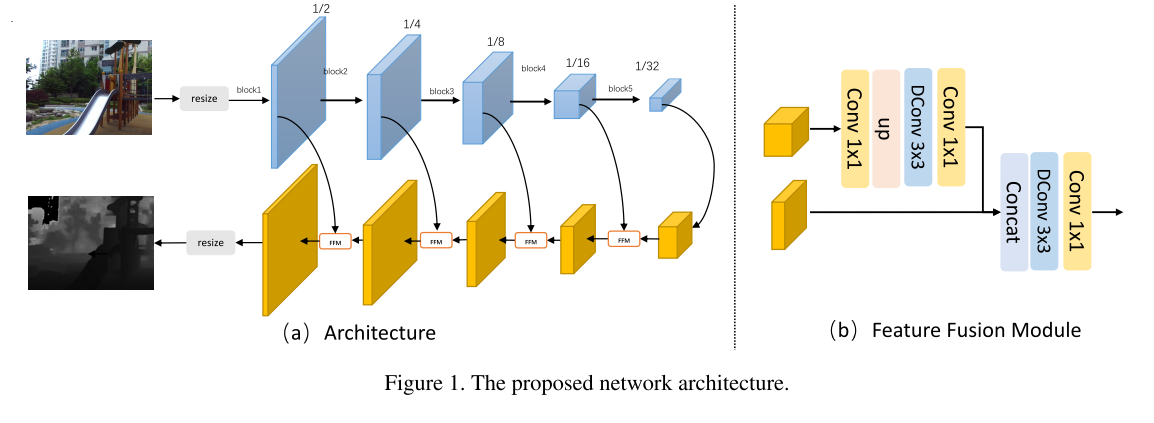

For this implementation, the encoder architecture uses the `timm` library. 

In [4]:
'''
Some codes are based off https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
'''
class Conv2dBnAct(nn.Module):
    def __init__(self, 
        in_channels, 
        out_channels, 
        kernel_size, 
        padding=0,
        stride=1, 
        act_layer=nn.ReLU, 
        norm_layer=nn.BatchNorm2d
    ):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class FeatureFusionModule(nn.Module):
    def __init__(self, 
        enc_in_channels, 
        enc_out_channels, 
        dec_in_channels, 
        out_channels
    ):
        super().__init__()

        #encoderoutput
        self.enc_conv1 = nn.Conv2d(enc_in_channels, enc_out_channels, kernel_size=1, stride=1, padding='same')
        self.enc_up = nn.ConvTranspose2d(enc_out_channels, enc_out_channels, kernel_size=1)
        self.enc_dconv = DepthwiseSeparableConv(enc_out_channels, enc_out_channels)
        self.enc_conv2 = nn.Conv2d(enc_out_channels, enc_out_channels, kernel_size=1, stride=1, padding='same')
        
        #decoderoutput
        self.dec_dconv = DepthwiseSeparableConv(enc_out_channels+dec_in_channels, enc_out_channels+dec_in_channels)
        self.dec_conv1 = nn.Conv2d(enc_out_channels+dec_in_channels, out_channels, kernel_size=1, stride=1, padding='same')


    def forward(self, enc_x, dec_x):
        enc_x = self.enc_conv1(enc_x)
        enc_x = self.enc_up(enc_x)
        enc_x = self.enc_dconv(enc_x)
        enc_x = self.enc_conv2(enc_x)
        
        x = torch.cat([enc_x, dec_x], dim=1)

        dec_x = self.dec_dconv(x)
        dec_x = self.dec_conv1(dec_x)
        
        return dec_x


class DecoderBlock(nn.Module):
    def __init__(self, 
        enc_channels, 
        dec_prev_channels, 
        dec_channels,
        act_layer=nn.ReLU, 
        norm_layer=nn.BatchNorm2d,
        ffm=True,
    ):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.ffm = ffm
        
        if ffm:
            self.ffm = FeatureFusionModule(enc_channels, enc_channels, dec_prev_channels, dec_channels)

        self.conv1 = Conv2dBnAct(enc_channels, dec_channels, norm_layer=norm_layer, **conv_args)
        self.conv2 = Conv2dBnAct(dec_channels, dec_channels, norm_layer=norm_layer, **conv_args)
        

    def forward(self, x_enc, x_dec):
        if self.ffm:
            x = self.ffm(x_enc, x_dec)

        x = F.interpolate(x_enc, scale_factor=2, mode='nearest')

        x = self.conv1(x)
        x = self.conv2(x)

        return x


class UnetDecoder(nn.Module):

    def __init__(self,
        encoder_channels,
        decoder_channels=(256, 128, 64, 32, 16),
        final_channels=3,
        norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        self.decoders = nn.ModuleList()
        for i, (e_ch, d_ch) in enumerate(zip(encoder_channels, decoder_channels)):
              if i== 0:
                  self.decoders.append(DecoderBlock(enc_channels=e_ch, 
                                                    dec_prev_channels=None, 
                                                    dec_channels=d_ch,
                                                    act_layer=nn.ReLU, 
                                                    norm_layer=nn.BatchNorm2d,
                                                    ffm=False,
                                                    ))

              else:
                  self.decoders.append(DecoderBlock(enc_channels=e_ch, 
                                                    dec_prev_channels=decoder_channels[i-1], 
                                                    dec_channels=d_ch,
                                                    act_layer=nn.ReLU, 
                                                    norm_layer=nn.BatchNorm2d,
                                                    ffm=True,
                                                    ))

        self.final_conv = nn.Conv2d(decoder_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        enc_outs_r = x
        dec_out = None
        for i, each in enumerate(self.decoders):
              dec_out = each(enc_outs_r[i], dec_out)
        x = self.final_conv(dec_out)
        return x


class Unet(nn.Module):
    def __init__(self,
        backbone='resnet50',
        backbone_kwargs=None,
        backbone_indices=None,
        decoder_use_batchnorm=True,
        decoder_channels=(256, 128, 64, 32, 16),
        in_chans=3,
        num_classes=3,
        norm_layer=nn.BatchNorm2d,
        pretrained=True,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=pretrained, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()
        x = self.decoder(x)
        return x

## The dataset

We will cheat a bit and use a dataset that comes with fastai to test this implementation.

To test this, we will use the `CAMVID` dataset. It has `32` classes. The codes for the dataloader is from Zach's [`WalkWithFastai` ](https://walkwithfastai.com/Segmentation) tutorial.

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

(#4) [Path('/root/.fastai/data/camvid/valid.txt'),Path('/root/.fastai/data/camvid/images'),Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/labels')]

In [6]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes, len(codes)

(array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
        'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
        'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
        'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
        'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
        'VegetationMisc', 'Void', 'Wall'], dtype='<U17'), 32)

In [7]:
fnames = get_image_files(path/"images")

In [8]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [9]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return np.mean(inp.argmax(dim=1)[mask].cpu().numpy()==targ[mask].cpu().numpy())

In [10]:
dls = SegmentationDataLoaders.from_label_func(path, 
                                              bs=8, 
                                              fnames = fnames, 
                                              label_func = label_func, 
                                              codes = codes,
                                              item_tfms=Resize((128, 160)))

## Training our model

In [14]:
model = Unet('mobilenetv3_rw',
             num_classes=32)

learn = Learner(dls, 
                model,
                metrics=acc_camvid)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_100-35495452.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_100-35495452.pth


We will use the default `CrossEntropy` loss and the `Adam` optimisers.

In [15]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [16]:
learn.opt_func

<function fastai.optimizer.Adam>

In [17]:
learn.fine_tune(25, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.595468,3.361859,0.241895,00:28
1,2.842299,2.296411,0.458541,00:27
2,2.193756,1.802174,0.530818,00:29


epoch,train_loss,valid_loss,acc_camvid,time
0,1.803018,1.764486,0.534220,00:29
1,1.762907,1.706282,0.545683,00:28
2,1.710568,1.636635,0.561695,00:28
3,1.638424,1.560829,0.582617,00:28
4,1.563859,1.482852,0.604542,00:28
5,1.486967,1.412253,0.622724,00:28
6,1.422374,1.353496,0.631442,00:28
7,1.365369,1.312228,0.639379,00:28
8,1.331338,1.279018,0.643833,00:28
9,1.297121,1.252835,0.649043,00:28


We are getting around 66% accuracy. Let's see how a large `ResNet` does?

## Training `resnet101` backbone to compare

In [11]:
learn_r101 = unet_learner(dls, 
                         resnet101, 
                         metrics=acc_camvid)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [12]:
learn_r101.fine_tune(5, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.084868,1.214263,0.792387,02:55
1,0.793003,0.826053,0.810637,02:33
2,0.688803,0.852149,0.821352,02:32


epoch,train_loss,valid_loss,acc_camvid,time
0,0.490857,0.525182,0.873040,02:39
1,0.493490,0.504035,0.868984,02:37
2,0.421950,0.410207,0.889949,02:37
3,0.355731,0.370287,0.904410,02:37
4,0.308405,0.360366,0.905570,02:37


In [18]:
ours = total_params(learn)[0]

In [19]:
r101 = total_params(learn_r101)[0]

In [20]:
print(f"The resnet101 is {r101/ours:.2f} larger than the implemented model")

The resnet101 is 55.61 larger than the implemented model


## Let's see if knowledge distilation helps

Knowledge distillation is a training technique that is used to distill/condense "knowledge" from large models on to smaller models. This is especially useful in situation that requires models to be deployed at the edge where computation is brought to the point at which data is produced. Below is an illustration of knowledge distillation technique.

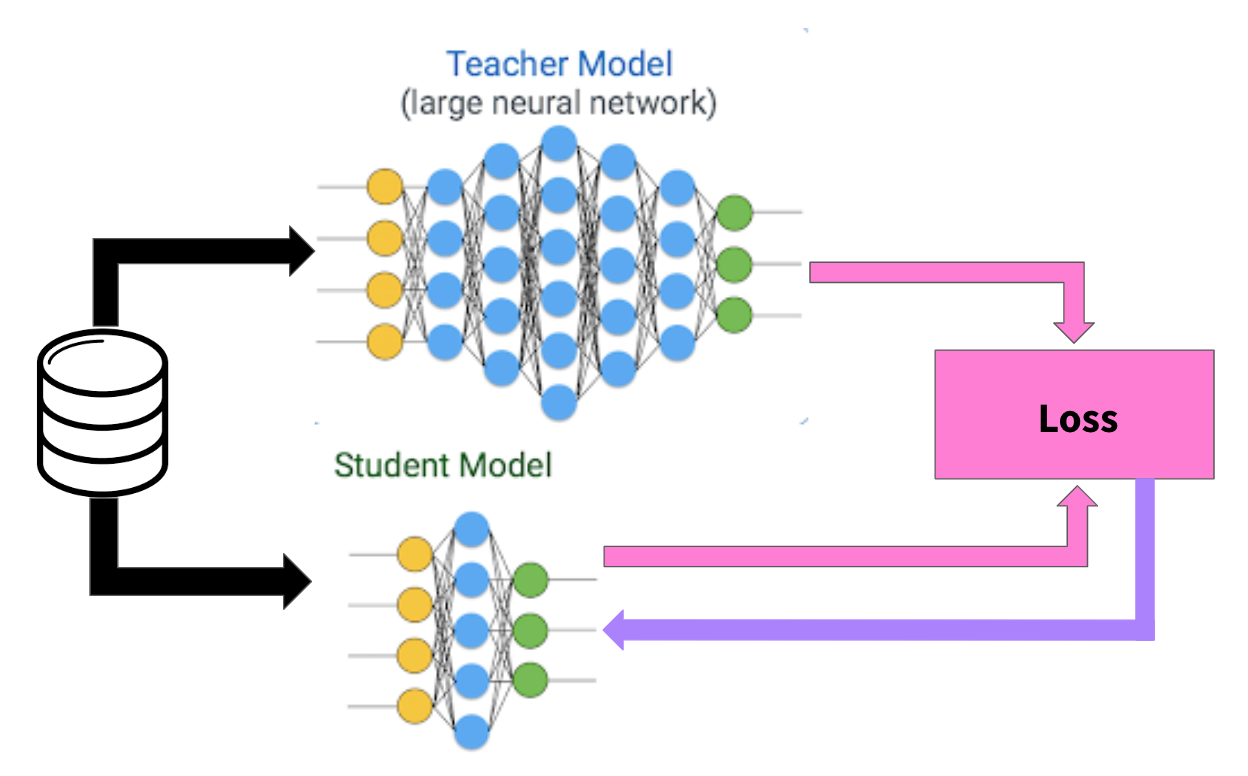

*source:https://towardsdatascience.com/knowledge-distillation-simplified-dd4973dbc764*

In [24]:
class DistillationLoss(nn.Module):
    def __init__(self):
        super(DistillationLoss, self).__init__()
        self.distillation_loss = nn.KLDivLoss(reduction='batchmean')
    
    def forward(self,
                student_preds,  
                teacher_preds, 
                acutal_target, 
                T, 
                alpha
                ):

        return self.distillation_loss(F.softmax(student_preds / T, dim=1).reshape(-1),
                                      F.softmax(teacher_preds / T, dim=1).reshape(-1))    


class KnowledgeDistillation(Callback):
    def __init__(self, 
                 teacher:Learner, 
                 T:float=20., 
                 a:float=0.7):
        super(KnowledgeDistillation, self).__init__()
        self.teacher = teacher
        self.teacher.eval()
        self.T, self.a = T, a
        self.distillation_loss = DistillationLoss()
    
    def after_loss(self):
        teacher_preds = self.teacher.model(self.learn.xb[0])
        student_loss = self.learn.loss_grad * self.a
        distillation_loss = self.distillation_loss(self.learn.pred, # Student preds
                                                   teacher_preds, #  Teacher preds
                                                   self.learn.yb, # Ground truth
                                                   self.T, 
                                                   self.a) * (1 - self.a)
        self.learn.loss_grad = student_loss + distillation_loss

We will use the resnet101 model as the teacher network.

In [25]:
model = Unet('mobilenetv3_rw',
             num_classes=32)

student_learn = Learner(dls, 
                        model,
                        metrics=acc_camvid,
                        cbs=[KnowledgeDistillation(teacher=learn_r101)])

In [26]:
student_learn.fine_tune(25, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.526798,3.317326,0.165013,02:28
1,2.873197,2.415550,0.453348,02:28
2,2.201838,1.803589,0.571052,02:27


epoch,train_loss,valid_loss,acc_camvid,time
0,1.767216,1.747058,0.575807,02:26
1,1.720115,1.682006,0.583318,02:28
2,1.665403,1.613305,0.593212,02:28
3,1.604016,1.539070,0.603386,02:28
4,1.521863,1.464969,0.617211,02:28
5,1.458398,1.406140,0.624710,02:28
6,1.404946,1.356212,0.630398,02:27
7,1.355936,1.317053,0.634496,02:28
8,1.317880,1.286721,0.640956,02:34
9,1.298382,1.260121,0.644317,02:37


The results show about the same accuracy but generally knowledge distillation requires longer training. 